In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
scaler = MinMaxScaler(feature_range=(-1, 1))

df = pd.read_csv('Google_Stock_Price_Train.csv')
df['Volume'] = df['Volume'].str.replace(',','').astype(float)
df['Close'] = df['Close'].str.replace(',','').astype(float)
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_test['Volume'] = df_test['Volume'].str.replace(',','').astype(float)
df_test.shape

(20, 6)

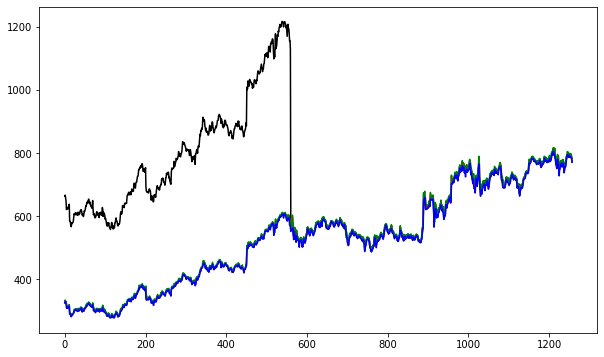

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df.Close, color='black')
plt.plot(df.Open, color='red')
plt.plot(df.High, color='green')
plt.plot(df.Low, color='blue')

In [9]:
def getData(d_f, days_before, M):
    data = []
    for i in range(len(d_f.to_numpy())-days_before): 
        data.append(d_f.to_numpy()[i: i+days_before])
    data = np.array(data)
    
    vali_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (vali_set_size)
    m = -1-M
    
    x_train = data[:train_set_size ,: -1 ,:]
    y_train = data[:train_set_size ,m:-1,:]
    x_vali = data[train_set_size :,: -1]
    y_vali = data[train_set_size:, m:-1,:]
    
    y_train_holder = []
    for i in range(len(y_train)):
        k = []
        for n in range(M):
            k.append(y_train[i][n][:])
        y_train_holder.append(k)
        
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    
    y_vali, y_train = np.array(y_vali_holder), np.array(y_train_holder)
    return [x_train, y_train, x_vali, y_vali]

In [10]:
def testData(d_f, days_before, M):
    data = []
    for i in range(len(d_f.to_numpy())-days_before): 
        data.append(d_f.to_numpy()[i: i+days_before])
    data = np.array(data)
    m = -1-M
    x_vali = data[:,: -1]
    y_vali = data[:, m:-1,:]
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    y_vali= np.array(y_vali_holder)
    return [x_vali, y_vali]

In [16]:
head_names = list(df.columns.values)[1:]
head_names_original = head_names.copy()
df_test_head_names = list(df_test.columns.values)[1:]
df_test_head_names_original = head_names.copy()
df_test = df_test[df_test_head_names_original]
for i in df_test_head_names_original:
    df_test[i] = scaler.fit_transform(df_test[i].values.reshape(-1,1))

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, input_sequence,M):
        h = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
        c = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
        out, (hh, cc) = self.lstm(input_sequence, (h.detach(), c.detach()))
        out = self.fc(out[:, -1, :]) 
        out = out.reshape(-1,M,5)
        return out

In [18]:
def calculate(volume, N, M, num_epochs, num_layers, col_name, x_train, x_vali, y_train_lstm, y_vali_lstm):
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train_lstm).float()
    y_vali_lstm = torch.tensor(y_vali_lstm).float()
    
    input_size = volume.shape[1]
    hidden_layer_size = N * input_size
    output_size = M*5
    
    model = LSTM(input_dim=input_size, hidden_dim=hidden_layer_size, output_dim=output_size, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    y_train_pred = []
    loss = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train,M)
        loss = criterion(y_train_pred, y_train_lstm)
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print("Epoch ", num_epochs, "MSE: ", loss.item())
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    y_train_lstm_plot = y_train_lstm.tolist()
    y_train_pred_plot = y_train_pred.tolist()
    
    pred_vali = model(x_vali,M)
    pred_vali_plot = pred_vali.tolist()
    y_vali_lstm_plot = y_vali_lstm.tolist()
    loss_rate = hist
    return y_train_lstm_plot, y_train_pred_plot, pred_vali_plot, y_vali_lstm_plot,loss_rate

In [34]:
def hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list):
    num_epochs = epochs_list
    y_train_lstm_list, y_train_pred_list, pred_vali_plot_list, y_vali_lstm_plot_list, loss_rate_list = [], [], [], [], []
    for i in head_names:
        df[i] = scaler.fit_transform(df[i].values.reshape(-1,1))
    volume = df[head_names_original]
    x_train, y_train, x_vali, y_vali = getData(volume, N, M)
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train).float()
    y_vali_lstm = torch.tensor(y_vali).float()
    

    for i in head_names:
        y_train_lstm, y_train_pred, pred_vali_plot, y_vali_lstm_plot, loss_rate = calculate(volume, N, 
            M, num_epochs, num_layers, i, x_train, x_vali, y_train_lstm, y_vali_lstm)
        y_train_lstm_list.append(y_train_lstm)
        y_train_pred_list.append(y_train_pred)
        loss_rate_list.append(loss_rate)
        pred_vali_plot_list.append(pred_vali_plot) 
        y_vali_lstm_plot_list.append(y_vali_lstm_plot)
    x = []

    for i in range(len(y_vali_lstm_plot_list[0])):
        x.append(i)
    fig = plt.figure(figsize=(10, 30))
    counter = 0
    for h in range(len(head_names)):
        for t in range(len(y_vali_lstm_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*y_vali_lstm_plot_list[h][t][q][h]
            y_vali_lstm_plot_list[h][t] = temp
        for t in range(len(pred_vali_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*pred_vali_plot_list[h][t][q][h]
            pred_vali_plot_list[h][t] = temp
    for i in range(len(head_names)):
        counter+=1
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'using past 7 days data to predict the next day'
        ax.set_title(title)
        plt.title = head_names[i]
        
        plt.plot(x,y_vali_lstm_plot_list[i], label = head_names[i]+' real_data')
        plt.plot(x,pred_vali_plot_list[i], label = head_names[i]+' predict')
        x_learning_curve = []
        plt.legend()
        counter+=1
        for k in range(len(loss_rate_list[i])):
            x_learning_curve.append(k)
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.plot(x_learning_curve, loss_rate_list[i], label = 'learning curve MSE: '+str(round(loss_rate_list[i][-1], 10)))
        plt.legend()
        plt.tight_layout()
    plt.legend()
    return y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended

Epoch  200 MSE:  0.0010154701303690672
Training time: 4.331528425216675
Epoch  200 MSE:  0.0009773354977369308
Training time: 4.0370283126831055
Epoch  200 MSE:  0.0010078870691359043
Training time: 4.022623538970947
Epoch  200 MSE:  0.001221795566380024
Training time: 4.005918025970459
Epoch  200 MSE:  0.0009703086689114571
Training time: 3.95806622505188


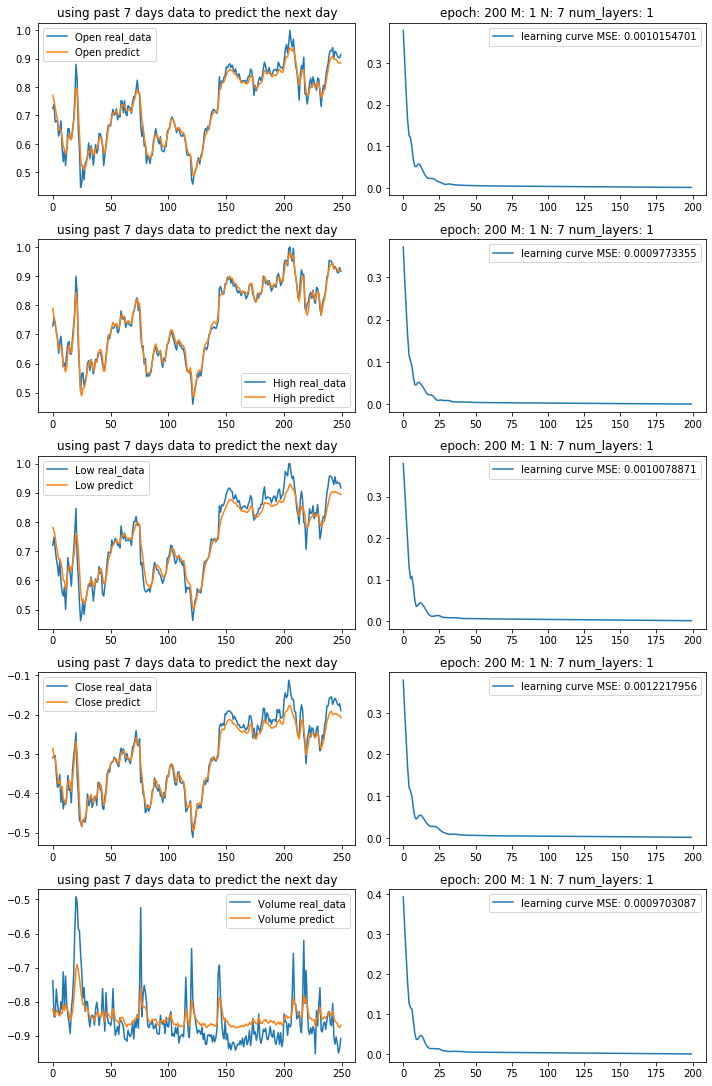

In [39]:
num_layers = 1
use_all_data = True
epochs_list = 200
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(df_test, 7, 1, num_layers, use_all_data, epochs_list)